<h1><center>Ames Housing Price Regression </center></h1>

<center><img src="https://www.searchinfluence.com/wp-content/uploads/2010/01/moneyhouses.jpg" align="center"/></center>

# Libraries & Configuration

## Import Libraries

In [416]:
# Warning Libraries 
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Scientific and Data Manipulation Libraries 
import pandas as pd
import numpy as np
import math
import gc
import os
import random

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

# Data Preprocessing, Machine Learning and Metrics Libraries 
from sklearn.preprocessing  import (LabelEncoder, 
                                              OneHotEncoder, OrdinalEncoder) 
from sklearn.preprocessing  import (StandardScaler, MinMaxScaler, 
                                              RobustScaler, MaxAbsScaler)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import f_regression, mutual_info_regression

# algorithms
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import (LinearRegression, RidgeCV,
                                  LassoCV, ElasticNetCV)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR, SVR

# Boosting Algorithms 
from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor

# metrics
from sklearn.metrics import (mean_squared_log_error, mean_squared_error,
                             mean_absolute_error, r2_score)
from sklearn.model_selection import (KFold, StratifiedKFold, RepeatedKFold, 
                                     train_test_split, cross_val_score,
                                     cross_val_predict)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

# Data Visualization Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px


from IPython.display import Markdown, display

# utility function to print markdown string
def printmd(string):
    display(Markdown(string))

# customize as needed
plt_params = {
    # 'figure.facecolor': 'white',
    'axes.facecolor' : 'white',

    ## to set size 
    # 'legend.fontsize': 'x-large',
    # 'figure.figsize': (15, 10),
    # 'axes.labelsize': 'x-large',
    # 'axes.titlesize': 'x-large',
    # 'xtick.labelsize': 'x-large',
    # 'ytick.labelsize': 'x-large'
}

plt.rcParams.update(plt_params)

sns.set_style('whitegrid')

# init_notebook_mode(connected=True)
# pio.renderers.default='notebook' # to display plotly graph
%matplotlib inline

## Configuration

In [306]:
SAMPLE_RATE = 0.4
EARLY_STOPPING_ROUND = 100

# seed value
SEED = 42

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

## Load Dataset

In [307]:
%%capture

# dataset source : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

# !pip install -q kaggle
# upload API key file : "kaggle.json"

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques

<a id='3'></a>
# EDA

In [308]:
# read data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')

## Descriptive Analysis

In [47]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


In [10]:
# Looks at the first 5 rows of the Train and Test data
printmd('### Train Head')
display(train.head())

printmd('### Test Head')
display(test.head())

### Train Head

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Test Head

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [314]:
# Display Information of Columns of Train and Test data
printmd('### Train Info')
display(train.info())

printmd('### Test Info')
display(test.info())

### Train Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

None

### Test Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

None

### Datatypes Distribution

In [309]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [310]:
test.dtypes.value_counts()

object     43
int64      26
float64    11
dtype: int64

### Features Summary

In [311]:
quantitative_features = [f for f in train.columns if train.dtypes[f] != 'object']

quantitative_features.remove('SalePrice')
quantitative_features.remove('Id')

qualitative_features = [f for f in train.columns if train.dtypes[f] == 'object']

print(len(qualitative_features), len(quantitative_features))

43 36


In [312]:
# Display Descriptive Statistics of Train and Test data
printmd('### Train Description')
display(train.describe().T)

printmd('### Test Description')
display(test.describe().T)

### Train Description

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


### Test Description

,count,mean,std,min,25%,50%,75%,max
Id,1459.0,2190.000000,421.321334,1461.0,1825.50,2190.0,2554.50,2919.0
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0


In [313]:
# Display Descriptive Statistics of categorical data
printmd('### Train Categorical Feature Description')
display(train.describe(include='object').T)

printmd('### Test Categorical Feature Description')
display(test.describe(include='object').T)

### Train Categorical Feature Description

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


### Test Categorical Feature Description

,count,unique,top,freq
MSZoning,1455,5,RL,1114
Street,1459,2,Pave,1453
Alley,107,2,Grvl,70
LotShape,1459,4,Reg,934
LandContour,1459,4,Lvl,1311
Utilities,1457,1,AllPub,1457
LotConfig,1459,5,Inside,1081
LandSlope,1459,3,Gtl,1396
Neighborhood,1459,25,NAmes,218
Condition1,1459,9,Norm,1251


### Check Duplicates

In [315]:
display(train[train.duplicated(keep=False)])

display(test[test.duplicated(keep=False)])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


## Missing Values

In [317]:
train.isna().sum().sum(), test.isna().sum().sum()

(6965, 7000)

In [316]:
def missing_value_describe(data):
    # check missing values in the data
    missing_value_pct_stats = (data.isnull().sum() / len(data)*100)
    missing_value_col_count = sum(missing_value_pct_stats > 0)

    missing_value_stats = missing_value_pct_stats.sort_values(ascending=False)[:missing_value_col_count]

    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    print("Number of rows with at least 1 missing values:", data.isna().any(axis = 1).sum())
    print("Number of columns with missing values:", missing_value_col_count)

    if missing_value_col_count != 0:
        # print out column names with missing value percentage
        print("\nMissing percentage (desceding):")
        print(missing_value_stats)

        # plot missing values
        missing = train.isnull().sum()
        missing = missing[missing > 0]
        missing.sort_values(inplace=True)
        missing.plot.bar()
    else:
        print("No missing data!!!")

Number of rows with at least 1 missing values: 1460
Number of columns with missing values: 19

Missing percentage (desceding):
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64


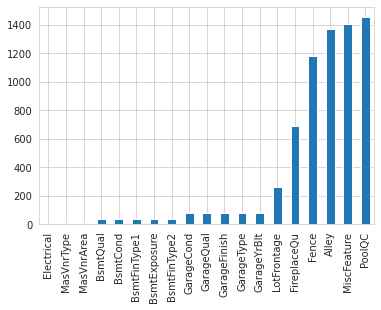

In [318]:
# pass a dataframe to the function
missing_value_describe(train)

Number of rows with at least 1 missing values: 1459
Number of columns with missing values: 33

Missing percentage (desceding):
PoolQC          99.794380
MiscFeature     96.504455
Alley           92.666210
Fence           80.123372
FireplaceQu     50.034270
LotFrontage     15.558602
GarageCond       5.346127
GarageQual       5.346127
GarageYrBlt      5.346127
GarageFinish     5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtQual         3.015764
BsmtExposure     3.015764
BsmtFinType1     2.878684
BsmtFinType2     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
BsmtHalfBath     0.137080
Utilities        0.137080
Functional       0.137080
BsmtFullBath     0.137080
BsmtFinSF2       0.068540
BsmtFinSF1       0.068540
Exterior2nd      0.068540
BsmtUnfSF        0.068540
TotalBsmtSF      0.068540
SaleType         0.068540
Exterior1st      0.068540
KitchenQual      0.068540
GarageArea       0.068540
GarageCars       0.068540
dtype: float64


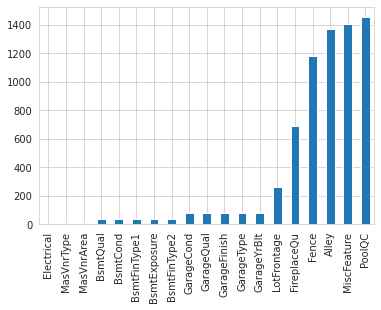

In [319]:
# pass a dataframe to the function
missing_value_describe(test)

## Normality Check

SalePrice skewness :  1.8828757597682129
SalePrice has to be normalized to perform regression


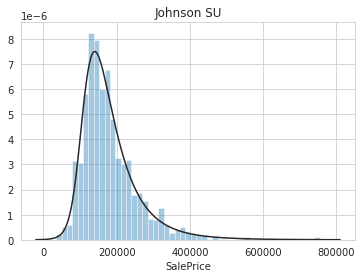

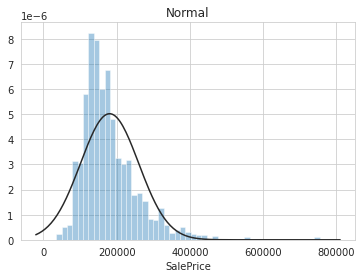

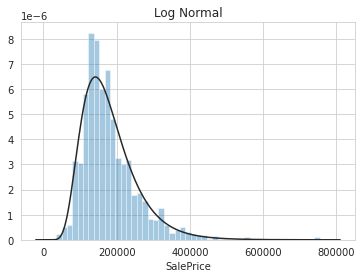

In [320]:
y = train['SalePrice']

print("SalePrice skewness : ", y.skew())

plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu);

plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm);

plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm);

print("SalePrice has to be normalized to perform regression")

In [321]:
# shapiro normality test
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01

normal = pd.DataFrame(train[quantitative_features])

normal = normal.apply(test_normality)

print(not normal.any())

 # No quantitive variables are normally distributed, need to transform those features as well 

False


## Correlation

### Spearman rank-order correlation
---
AKA Spearman's rho or Spearman correlation coefficient\
Applied to **Continuous or ordinal**

<br>

**Unlike the Pearson correlation**, the Spearman correlation does not assume that both datasets are **normally distributed**

Pearson correlation assumes normality, linearity and homoscedasticity.Pearson's correlation is also not able to tell the difference between dependent and independent variables

Hypotheses -

* H0: the two samples do not have monotonic relationship
* H1: there is a monotonic relationship between the samples

For Pearson r correlation, both variables should be normally distributed

According to the normality test tenure, MonthlyCharges and TotalCharges columns are **not normally distributed** 

#### Encode Categorical Features

In [322]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative_features:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [427]:
len(qual_encoded)

43

#### Plot Correlation

##### Spearman Bar Plot 

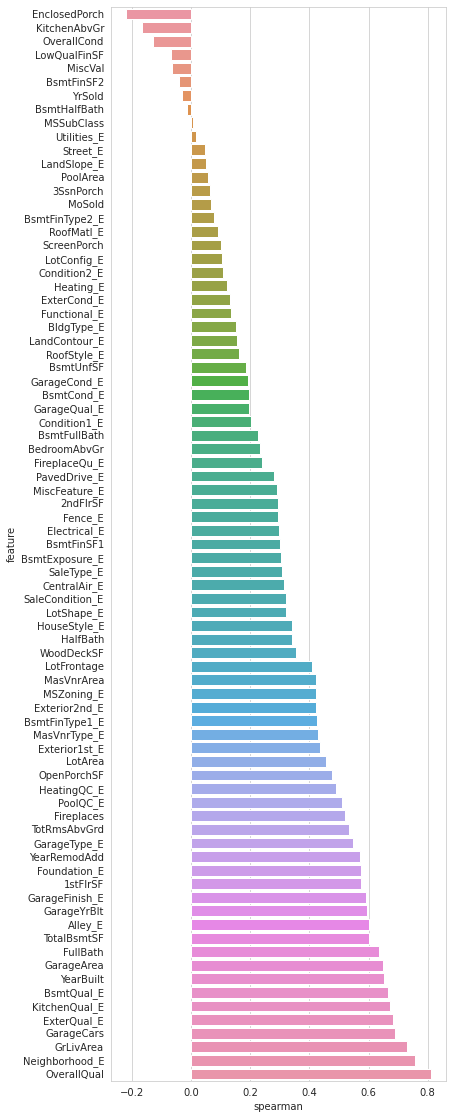

In [323]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative_features + qual_encoded

spearman(train, features)

##### Heatmap

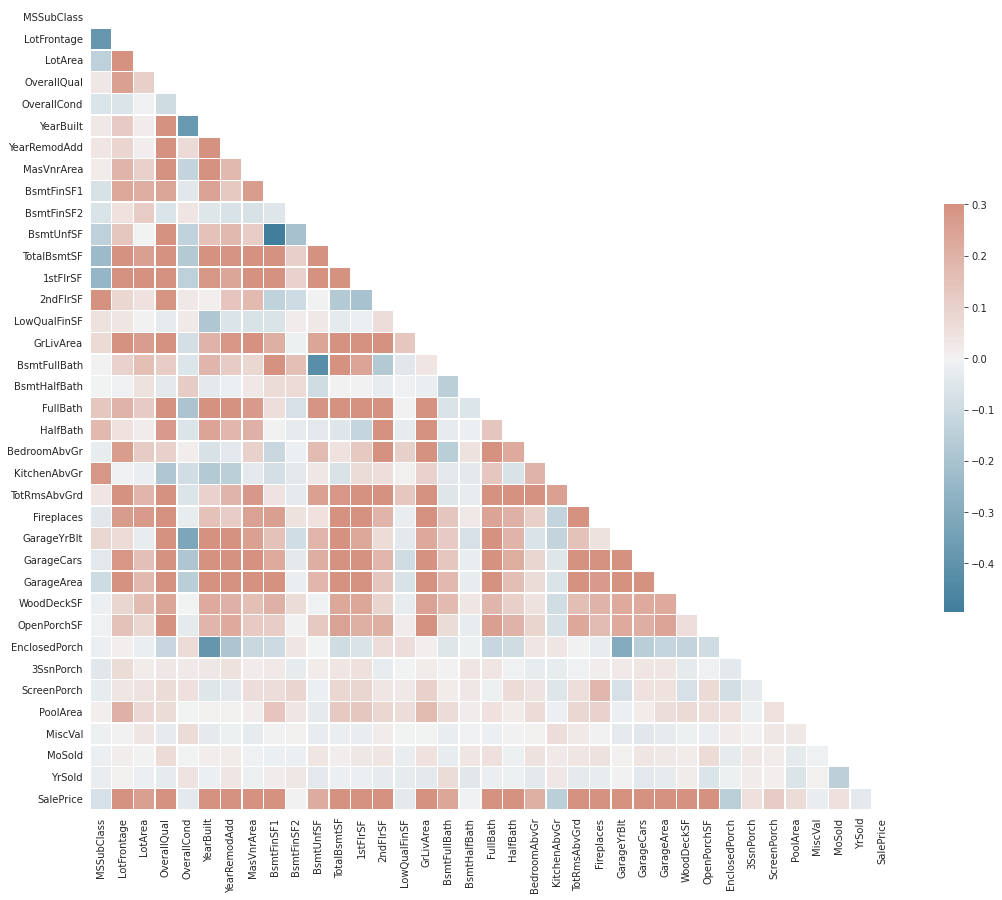

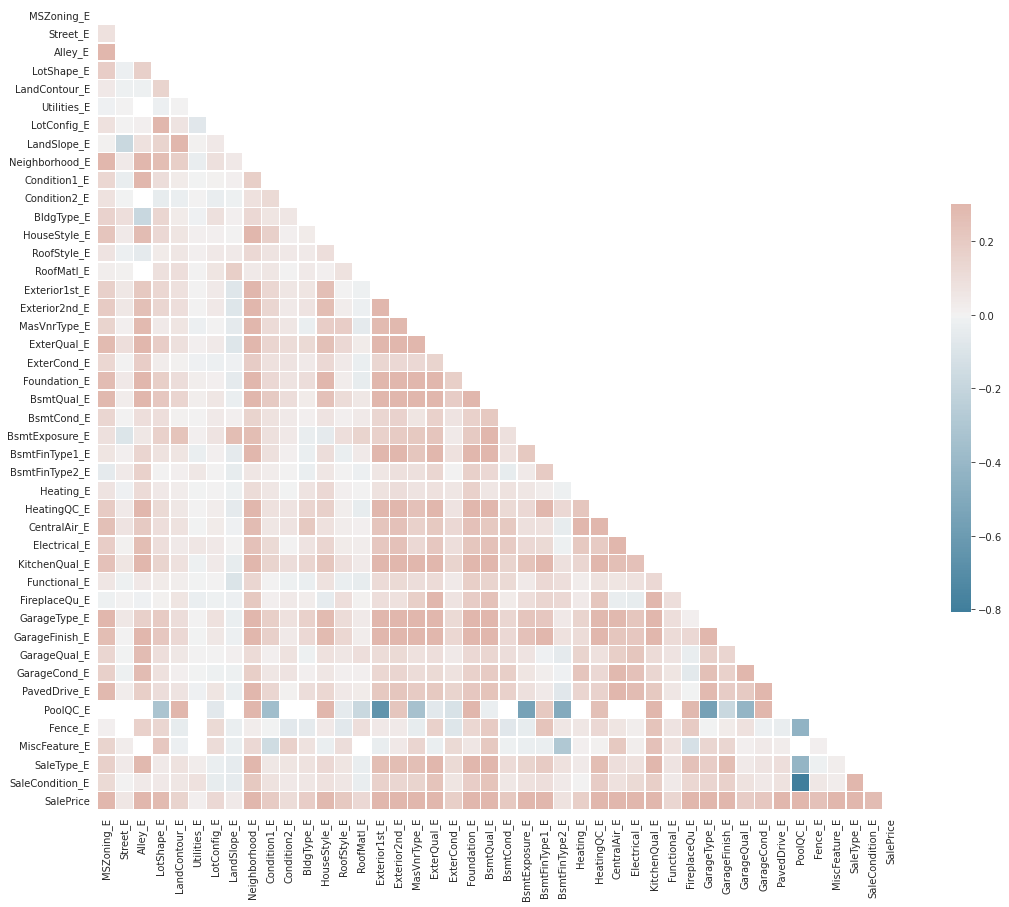

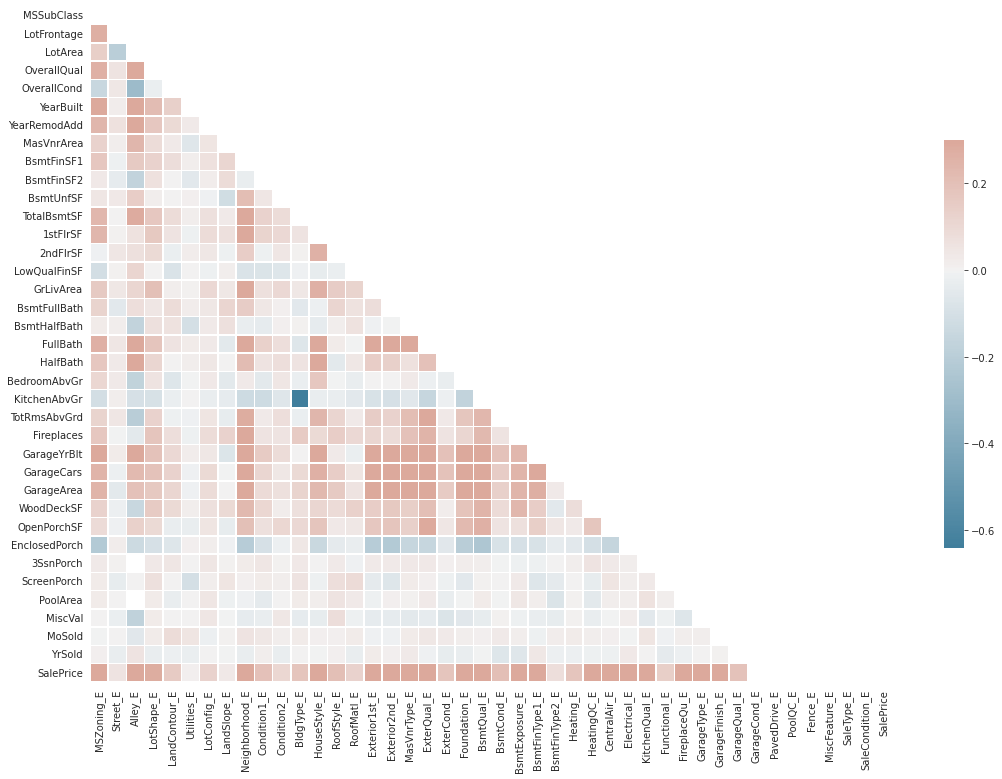

In [390]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(1, figsize=(18,15))
corr = train[quantitative_features+['SalePrice']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.figure(2, figsize=(18,15))
corr = train[qual_encoded+['SalePrice']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.figure(3, figsize=(18,15))
corr = pd.DataFrame(np.zeros([len(quantitative_features)+1, len(qual_encoded)+1]), index=quantitative_features+['SalePrice'], columns=qual_encoded+['SalePrice'])
mask = np.triu(np.ones_like(corr, dtype=bool))

for q1 in quantitative_features+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
# todo clustering

# Data Preparation

Drop Id

In [325]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [326]:
train.reset_index(drop=True, inplace=True)

# normalize target
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

 Prepare Feature Set

In [327]:
train_features_df = train.drop(['SalePrice'], axis=1)
test_features_df = test.copy()
features_df = pd.concat([train_features_df, test_features_df]).reset_index(drop=True)
features_df.shape

(2919, 122)

### Change Datatypes

In [328]:
features_df[['MoSold', 'YrSold', 'MSSubClass']]

# MSSubClass: Identifies the type of dwelling involved in the sale

# MoSold: Month Sold (MM)

# YrSold: Year Sold (YYYY)

,MoSold,YrSold,MSSubClass
0,2,2008,60
1,5,2007,20
2,9,2008,60
3,2,2006,70
4,12,2008,60
...,...,...,...
2914,6,2006,160
2915,4,2006,160
2916,9,2006,20
2917,7,2006,85


In [329]:
features_df['MSSubClass'] = features_df['MSSubClass'].apply(str)
features_df['YrSold'] = features_df['YrSold'].astype(str)
features_df['MoSold'] = features_df['MoSold'].astype(str)

Drop Irrelevant Features

In [330]:
#  For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
# Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling
features_df.drop(['Utilities'], axis=1, inplace=True)

# Street could be a good candidate since except 12 counts 'Grvl' all of them are 'Pave' category      

### Imputation

In [331]:
# https://stackoverflow.com/a/38886211/11105356

# GarageYrBlt, Electrical, LotFrontage      

features_df.loc[:, "Alley"] = features_df.loc[:, "Alley"].fillna("NA")

features_df.loc[:, "BsmtCond"] = features_df.loc[:, "BsmtCond"].fillna("NA")

features_df.loc[:, "BsmtExposure"] = features_df.loc[:, "BsmtExposure"].fillna("NA") # No - no exposure

features_df.loc[:, "BsmtFinType1"] = features_df.loc[:, "BsmtFinType1"].fillna("NA")

features_df.loc[:, "BsmtFinType2"] = features_df.loc[:, "BsmtFinType2"].fillna("NA")

features_df.loc[:, "BsmtQual"] = features_df.loc[:, "BsmtQual"].fillna("NA")


features_df.loc[:, "Fence"] = features_df.loc[:, "Fence"].fillna("No")

features_df.loc[:, "FireplaceQu"] = features_df.loc[:, "FireplaceQu"].fillna("NA")


features_df.loc[:, "GarageCond"] = features_df.loc[:, "GarageCond"].fillna("NA")

features_df.loc[:, "GarageQual"] = features_df.loc[:, "GarageQual"].fillna("NA")
    
features_df.loc[:, "GarageType"] = features_df.loc[:, "GarageType"].fillna("NA")

features_df.loc[:, "GarageFinish"] = features_df.loc[:, "GarageFinish"].fillna("NA")

features_df.loc[:, "MiscFeature"] = features_df.loc[:, "MiscFeature"].fillna("NA")

features_df.loc[:, "MasVnrArea"] = features_df.loc[:, "MasVnrArea"].fillna(0)

features_df.loc[:, "MasVnrType"] = features_df.loc[:, "MasVnrType"].fillna("None")


for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features_df.loc[:, col] = features_df.loc[:, col].fillna(0)


features_df.loc[:, "PoolQC"] = features_df.loc[:, "PoolQC"].fillna("TA")

features_df.loc[:, "Functional"] = features_df.loc[:, "Functional"].fillna("Typ")

features_df.loc[:, "KitchenQual"] = features_df.loc[:, "KitchenQual"].fillna("TA")

# imputation based on frequency

features_df.loc[:, "Electrical"] = features_df.loc[:, "Electrical"].fillna(features_df['Electrical'].mode()[0])
features_df.loc[:, "Exterior1st"] = features_df.loc[:, "Exterior1st"].fillna(features_df['Exterior1st'].mode()[0])
features_df.loc[:, "Exterior2nd"] = features_df.loc[:, "Exterior2nd"].fillna(features_df['Exterior2nd'].mode()[0])
features_df.loc[:, "LotFrontage"] = features_df.loc[:, "LotFrontage"].fillna(features_df['LotFrontage'].mode()[0])
features_df.loc[:, "SaleType"] = features_df.loc[:, "SaleType"].fillna(features_df['SaleType'].mode()[0])
features_df.loc[:, "MSZoning"] = features_df.loc[:, "MSZoning"].fillna(features_df['MSZoning'].mode()[0])
 
features_df.loc[:, "GarageYrBlt"] = features_df.loc[:, "GarageYrBlt"].fillna(0)

In [332]:
features_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,...,LotShape_E,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,...,1.0,2.0,2.0,1.0,1.0,17.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,1.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,NaN,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,...,1.0,2.0,2.0,2.0,1.0,21.0,3.0,5.0,5.0,6.0,2.0,3.0,5.0,6.0,2.0,2.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,6.0,5.0,2.0,5.0,2.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,...,2.0,2.0,2.0,1.0,1.0,17.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,2.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,...,2.0,2.0,2.0,3.0,1.0,18.0,5.0,5.0,5.0,7.0,2.0,3.0,6.0,9.0,2.0,2.0,4.0,2.0,2.0,4.0,1.0,4.0,5.0,6.0,4.0,2.0,5.0,3.0,7.0,4.0,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,...,2.0,2.0,2.0,2.0,1.0,25.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,3.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0


In [333]:
features_df.select_dtypes('object').fillna('NA', inplace=True)

for col in features_df.select_dtypes(exclude=['object']).columns:
    features_df[col] = features_df[col].fillna(0)

In [334]:
features_df.isna().sum().sum()

0

In [335]:
features_df.shape

(2919, 121)

## Skewed Features

In [392]:
numeric_features = features_df.dtypes[features_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = features_df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkewness in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skewness in numerical features: 



,Skew
PoolQC_E,22.954840
PoolArea,15.119426
3SsnPorch,8.924822
LowQualFinSF,8.744143
MiscFeature_E,7.305522
Alley_E,5.895238
MiscVal,5.597060
BsmtHalfBath,3.788243
KitchenAbvGr,3.698825
ScreenPorch,2.978396


### Normalize Features

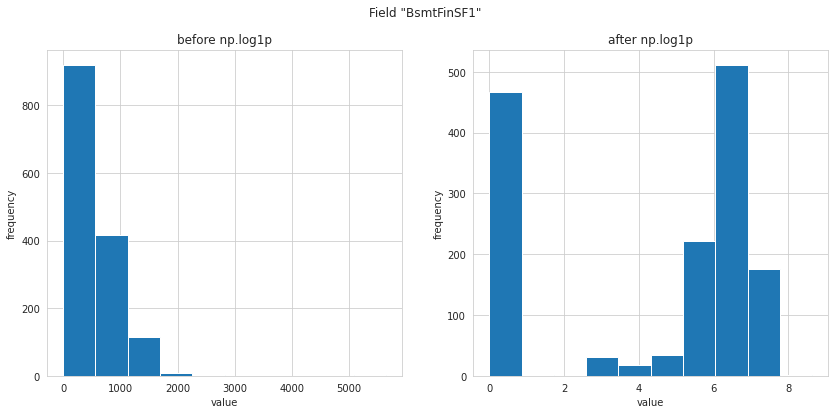

In [398]:
field = "BsmtFinSF1"
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(14, 6))
train[field].hist(ax=ax_before)
train[field].apply(np.log1p).hist(ax=ax_after)
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

In [337]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to transform".format(skewness.shape[0]))


skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    features_df[feat] = boxcox1p(features_df[feat], lam)

There are 76 skewed numerical features to Box Cox transform


## One Hot Encoding

In [465]:
final_features_df = pd.get_dummies(features_df).reset_index(drop=True)
final_features_df = final_features_df.loc[:,~final_features_df.columns.duplicated()]
final_features_df.shape

(2919, 373)

## Train / Test Split

In [466]:
X = final_features_df.iloc[:len(y), :]
X_sub = final_features_df.iloc[len(y):, :]

X.shape, y.shape, X_sub.shape

((1460, 373), (1460,), (1459, 373))

In [467]:
# Select categorical columns with relatively low cardinality, threshold=10
low_c_categorical_cols = [cname for cname in X.columns if X[cname].nunique() <= 10 and 
                        X[cname].dtype == "object"]

# Select categorical columns with relatively high cardinality
high_c_categorical_cols = [cname for cname in X.columns if X[cname].nunique() > 10 and 
                        X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Modeling

## Classic ML Models

0.1325435228207959


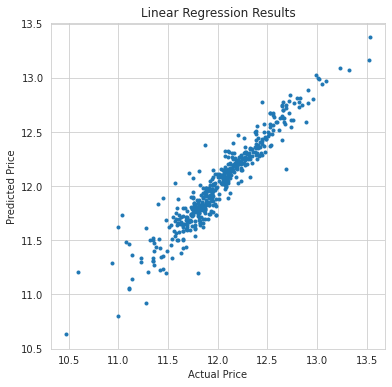

In [404]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=SEED )

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))


linearRegression = LinearRegression().fit(X_train, y_train)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

print(linearRegression_rmse)


f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, linearRegression.predict(X_test), 
         marker='o', ls='', ms=3.0)

# lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
      #  xlim=lim,
      #  ylim=lim,
       title='Linear Regression Results');

## Preprocessing Pipeline

In [475]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Preprocessing for categorical data
low_c_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore',  sparse=False))
])

high_c_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore',  sparse=False))
    # ('ord', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        # ('low_c_cat', low_c_categorical_transformer, low_c_categorical_cols),
        # ('high_c_cat', high_c_categorical_transformer, high_c_categorical_cols)
    ])

kf = KFold(n_splits=10,random_state=SEED, shuffle=True)
# rep_kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Bundle preprocessing and modeling code in a pipeline

def evaluate_model(model):
  # estimator = Pipeline(steps=[('preprocessor', preprocessor),
  #                               ('model', model)
  #                             ])
  estimator = Pipeline(steps=[('scaler', RobustScaler()),
                                ('model', model)
                              ])
  return np.sqrt(-cross_val_score(estimator, X, y, 
                                  scoring="neg_mean_squared_error", 
                                  cv = kf, n_jobs=-1))

In [476]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
l1_ratios = np.linspace(0.1, 0.9, 9)


ridge_cv = RidgeCV(alphas=alphas, cv=kf)
lasso_cv = LassoCV(alphas=alphas2, max_iter=5e4, cv=kf)
elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4)
forest = RandomForestRegressor(n_estimators=100, random_state=0)
xgb = XGBRegressor(objective='reg:squarederror')

score_ridge = evaluate_model(ridge_cv)
print("Ridge: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))

score_lasso = evaluate_model(lasso_cv)
print("LASSO: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))

score_enet = evaluate_model(elasticNetCV)
print("Elastic net: {:.4f} ({:.4f})\n".format(score_enet.mean(), 
                                              score_enet.std()))


score_forest = evaluate_model(forest)
print("Random Forest: {:.4f} ({:.4f})\n".format(score_forest.mean(), 
                                                score_forest.std()))
score_xgb = evaluate_model(xgb)
print("XGBRegressor: {:.4f} ({:.4f})\n".format(score_xgb.mean(), 
                                                score_xgb.std()))

Ridge: 0.1256 (0.0244)

LASSO: 0.1231 (0.0251)

Elastic net: 0.1230 (0.0251)

Random Forest: 0.1392 (0.0220)

XGBRegressor: 0.1253 (0.0188)



In [437]:
X.shape, X_sub.shape

((1460, 373), (1459, 373))

<a id='10.5.5'></a>

## Stacking Ensemble

>knn 0.192 (0.021)
>dtree 0.193 (0.020)
>rforest 0.138 (0.022)
>svm 0.140 (0.024)
>lasso 0.377 (0.032)
>ridge 0.132 (0.026)
>stacking 0.123 (0.025)


<br>

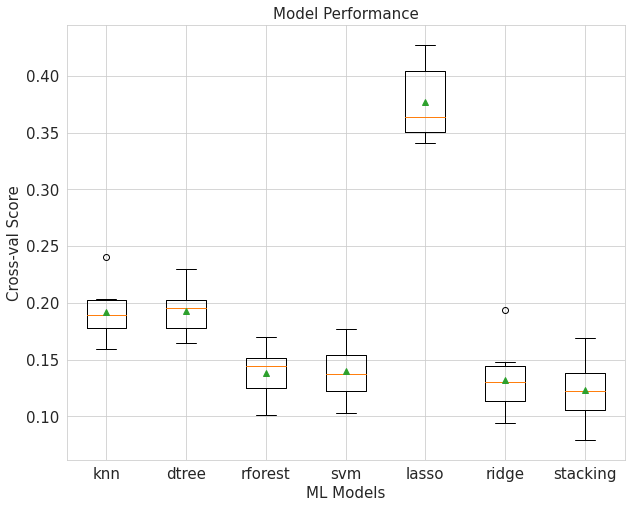

In [477]:
# get a stacking ensemble of models
def get_stacking():
  # define the base models
  level0 = list()
  level0.append(('knn', KNeighborsRegressor()))
  level0.append(('dtree', DecisionTreeRegressor()))
  level0.append(('rforest', RandomForestRegressor()))
  level0.append(('svm', SVR()))
  level0.append(('lasso', Lasso()))
  level0.append(('ridge', Ridge()))

  # define meta learner model
  level1 = LinearRegression()

  # define the stacking ensemble
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
  return model

# get a list of models to evaluate
def get_models():
  models = dict()
  models['knn'] = KNeighborsRegressor()
  models['dtree'] = DecisionTreeRegressor()
  models['rforest'] = RandomForestRegressor()
  models['svm'] = SVR()
  models['lasso'] = Lasso()
  models['ridge'] = Ridge()
  models['stacking'] = get_stacking()
  return models


# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
 
printmd("<br>")

# plot model performance for comparison
font_size = 15
plt.figure(figsize=(10,8))
plt.boxplot(results, labels=names, showmeans=True)

plt.title("Model Performance",  fontsize=font_size)
plt.xlabel("ML Models", fontsize=font_size)
plt.ylabel("Cross-val Score",  fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.show()


# credit : https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python

<a id='10.5.5'></a>
## Deep Learning Model

In [478]:
scaler = RobustScaler()
X_transformed = scaler.fit_transform(X)

In [479]:
X_transformed.shape

(1460, 373)

In [480]:
def build_model():
  model = Sequential()
  model.add(Dense(32, activation='relu', input_shape=(X_transformed.shape[1],)))
  model.add(Dense(64, activation='relu'))
  # model.add(Dense(32, activation='relu'))
  model.add(Dense(1)) # linear layer
  model.compile(optimizer='rmsprop', # rmsprop
                loss='mse', 
                metrics=['mae']) # mae
  return model

In [481]:
model = build_model()
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 32)                11968     
_________________________________________________________________
dense_73 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 65        
Total params: 14,145
Trainable params: 14,145
Non-trainable params: 0
_________________________________________________________________


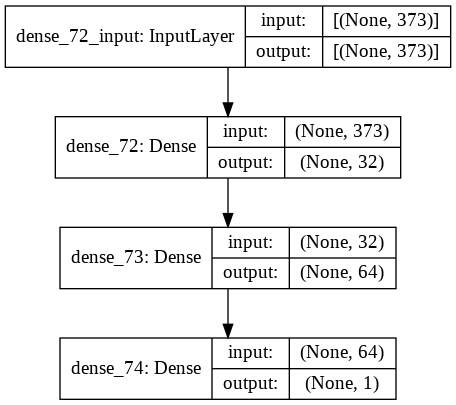

In [484]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [482]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_transformed, y, epochs=30, 
                    batch_size=1, 
                    validation_split=0.3, 
                    # callbacks=[callback]
                    )

Epoch 1/30
1021/1021 [==============================] - 3s 2ms/step - loss: 8.0470 - mae: 1.6802 - val_loss: 0.9032 - val_mae: 0.7007
Epoch 2/30
1021/1021 [==============================] - 2s 2ms/step - loss: 0.6598 - mae: 0.6106 - val_loss: 0.5612 - val_mae: 0.5377
Epoch 3/30
1021/1021 [==============================] - 2s 2ms/step - loss: 0.4609 - mae: 0.5057 - val_loss: 0.2234 - val_mae: 0.3603
Epoch 4/30
1021/1021 [==============================] - 2s 2ms/step - loss: 0.3663 - mae: 0.4466 - val_loss: 0.3765 - val_mae: 0.4687
Epoch 5/30
1021/1021 [==============================] - 2s 2ms/step - loss: 0.2924 - mae: 0.4104 - val_loss: 0.3698 - val_mae: 0.4825
Epoch 6/30
1021/1021 [==============================] - 2s 2ms/step - loss: 0.2512 - mae: 0.3921 - val_loss: 0.1783 - val_mae: 0.3218
Epoch 7/30
1021/1021 [==============================] - 2s 1ms/step - loss: 0.2277 - mae: 0.3603 - val_loss: 0.1591 - val_mae: 0.2912
Epoch 8/30
1021/1021 [==============================] - 2s 2ms

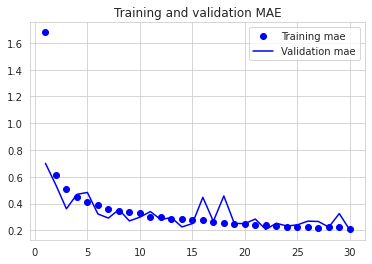

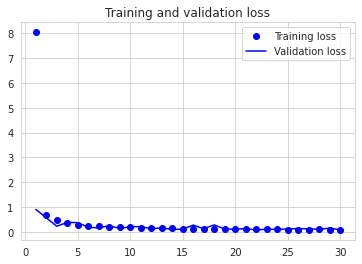

In [483]:
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training mae')
plt.plot(epochs, val_acc, 'b', label='Validation mae')

plt.title('Training and validation MAE')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()